In [2]:
import scipy
import scipy.linalg
import scipy.sparse.linalg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# a) We will use the convention : 0 = up, 1 = down
up, down = 0, 1

Mo = np.zeros([1, 2, 2]) # l(eft) p(hysical) r(ight)
Me = np.zeros([2, 2, 1])

Mo[:, up, :]  = [[np.sqrt(2)**(-1), 0.]]   #(1x2) matrices
Mo[:, down, :] = [[0.,-1.*np.sqrt(2)**(-1)]]

Me[:, up, :] = [[0], #(2x1) matrices
                [1]]
Me[:, down, :] = [[1], 
                  [0]]

phi0 = np.zeros([1, 2, 1]) # free spin on the edges
phi0[:, up, :] = 1         # put them up

L = 50
singlet_mps = [phi0] + [Mo, Me] * ((L-2)//2) + [phi0]

In [9]:
# b)
def overlap(mps_bra, mps_ket):
    L = len(mps_bra)
    assert L == len(mps_ket)
    contr = np.ones((1,1)) # has indices (alpha_n*, alpha_n), which we label vR* vR
    for n in range(L):
        M_ket = mps_ket[n]  # has indices (alpha_n, j_n, alpha_{n+1}) -> vL j vR
        contr = np.tensordot(contr, M_ket , axes=(1, 0)) # vR* [vR], [vL] j vR contract indices in []
        # now contr has indices vR* j vR
        M_bra = mps_bra[n].conj()  # vL* j* vR*
        contr = np.tensordot(M_bra, contr, axes=([0, 1], [0, 1])) # [vL*] [j*] vR*, [vR*] [j] vR
    assert contr.shape == (1, 1)
    return contr.item()

norm_singlet = overlap(singlet_mps,singlet_mps)
print(f"norm of the state: {norm_singlet:0.5f}")

sigma_z = np.array([[1.,0.],[0.,-1.]])

def apply_1_site_operator(mps_bra, op, site):
    '''Applies a one-site operator on a given site of a given MPS.
    Uses a copy so doesn't modify the given MPS.'''
    mps_bra_op = mps_bra.copy()
    assert site < len(mps_bra)
    mps_bra_op[site] = np.tensordot(mps_bra_op[site], op, axes=(1, 0)) # vL [j] vR, [j*] j
    mps_bra_op[site]  = mps_bra_op[site].transpose([0, 2, 1]) # vL j vR
    return mps_bra_op

def calculate_correlation(mps_bra, op, i, j):
    '''Computes the operator correlation between site i and j of the given MPS '''
    mps_flip_i = apply_1_site_operator(mps_bra, op, i)
    si = overlap(mps_bra, mps_flip_i)

    mps_flip_j = apply_1_site_operator(mps_bra, op, j)
    sj = overlap(mps_bra, mps_flip_j)

    mps_flip_ij = apply_1_site_operator(mps_flip_i, op, j)
    return overlap(mps_bra, mps_flip_ij) - si*sj

i, j = 1,2
corr = calculate_correlation(singlet_mps, sigma_z, i, j)
print(f"correlation between site {i:d} and {j:d}: {corr:0.5f}")

i, j = 1,3
corr = calculate_correlation(singlet_mps, sigma_z, i, j)
print(f"correlation between site {i:d} and {j:d}: {corr:0.5f}")

norm of the state: 1.00000
correlation between site 1 and 2: -1.00000
correlation between site 1 and 3: 0.00000


In [5]:
 # c) Spin-1 projector
P = np.zeros([3, 2, 2]) # Convention: spin1, 2 x spin1/2 (left/right), label jS1 j1* j2*
# order of spin-1 states: 0 -> |-1>, 1 -> |0>, 2 -> |1>
P[0, down, down] = 1
P[1, :, :] = np.sqrt(0.5) * np.array([[0, 1], [1, 0]])
P[2, up, up] = 1

# Apply this projector to the singlet MPS
aklt_mps = []
for i in range(0, L , 2):
    M = np.tensordot(singlet_mps[i], singlet_mps[i+1], axes=[2, 0])  # vL j1 [vR], [vL] j2 vR
    M = np.tensordot(P, M, axes=[[1, 2], [1, 2]]) # jS1 [j1*] [j2*] vL, [j1] [j2] vR
    M = M.transpose([1, 0, 2]) # vL jS1 vR
    aklt_mps.append(M)

In [6]:
norm_aklt = overlap(aklt_mps,aklt_mps)
print("norm of the AKLT state: {norm_aklt:0.10f}")

print("Bulk tensor looks almost left-canonical:")
M = aklt_mps[1].copy()
# Check the canonical form of the bulk tensor M:
fix_left = np.tensordot(M, M.conj(), axes=([0,1],[0,1]))
print(fix_left)

print("Make bulk tensor left-canonical:")
M *= np.sqrt(4/3)
for i in range(1,len(aklt_mps)-1):
    aklt_mps[i] *= np.sqrt(4/3)
fix_left = np.tensordot(M, M.conj(), axes=([0,1],[0,1]))
print(fix_left)

print("This gives the MPS respresentation of the AKLT ground state that you will find in the literature: ")
print("+1", M[:,2,:])
print("0", M[:,1,:])
print("-1",M[:,0,:])

norm of the AKLT state: 0.0007525435
Bulk tensor looks almost left-canonical:
[[0.75 0.  ]
 [0.   0.75]]
Make bulk tensor left-canonical:
[[1. 0.]
 [0. 1.]]
This gives the MPS respresentation of the AKLT ground state that you will find in the literature: 
+1 [[0.         0.        ]
 [0.81649658 0.        ]]
0 [[ 0.57735027  0.        ]
 [ 0.         -0.57735027]]
-1 [[ 0.         -0.81649658]
 [ 0.          0.        ]]


i.e.


$$
\begin{align}
    M^{[n] +1} & = \sqrt{\frac{4}{3}}\begin{pmatrix} 0 & 0 \\ \frac{1}{\sqrt{2}} & 0 \end{pmatrix}
    &
    M^{[n] 0} & = \sqrt{\frac{4}{3}}\begin{pmatrix} \frac{1}{2} & 0 \\ 0 & -\frac{1}{2} \end{pmatrix}
    &
    M^{[n] -1} & = \sqrt{\frac{4}{3}}\begin{pmatrix} 0 & -\frac{1}{\sqrt{2}} \\ 0 & 0 \end{pmatrix}
    .\label{eq:AKLT}
\end{align}
$$

In [10]:
# d) check normalization
norm_aklt = overlap(aklt_mps,aklt_mps)
print("norm of the AKLT state: {norm:0.10f}".format(norm=norm_aklt))
aklt_mps[0] /= np.sqrt(norm_aklt) # make MPS normlized
norm_aklt = overlap(aklt_mps,aklt_mps)
print("norm of the AKLT state after renormalizing: {norm:0.5f}".format(norm=norm_aklt))

norm of the AKLT state: 1.0000000000
norm of the AKLT state after renormalizing: 1.00000


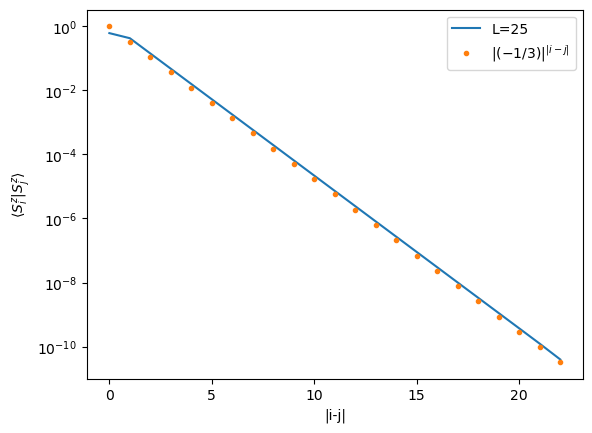

In [11]:
# e) correlations in the AKLT state
Sz = np.array([[1.,0.,0],[0.,0,0],[0.,0.,-1.]]) # spin-1 Sz operator
corrs = []
ds = []
i = 1
d_max = len(aklt_mps)-1

for d in range(d_max-i):
    j = i + d
    corrs.append(calculate_correlation(aklt_mps, Sz, i, j))
    ds.append(d)


plt.figure()
plt.semilogy(ds,np.abs(corrs),label="L={L:d}".format(L=len(aklt_mps)))
plt.semilogy(ds, np.abs([(-1/3)**(d) for d in ds]),'.',label=r"$ |(-1/3)|^{|i-j|}$")
plt.xlabel("|i-j|")
plt.ylabel(r"$\langle S^z_i | S^z_j \rangle $")
plt.legend()
plt.show()